# This is my 35th. Laptop Price Prediction Project

# Import Required Libraries

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & splitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost
from xgboost import XGBRegressor

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Save the model
import joblib

# Load Dataset

In [2]:
data = pd.read_csv('laptopData.csv')
data.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [3]:
data.duplicated().sum()

29

# Remove Duplicates

In [4]:
data = data.drop_duplicates()

In [5]:
data.duplicated().sum()

0

In [6]:
data.isna().sum()

Unnamed: 0          1
Company             1
TypeName            1
Inches              1
ScreenResolution    1
Cpu                 1
Ram                 1
Memory              1
Gpu                 1
OpSys               1
Weight              1
Price               1
dtype: int64

# Handle Missing values

In [7]:
data.dropna(inplace=True)

In [8]:
cat = data.select_dtypes(include='object')
for i in cat.columns:
    print(f"{i}")
    print(f"{cat[i].nunique()}")

Company
19
TypeName
6
Inches
25
ScreenResolution
40
Cpu
118
Ram
10
Memory
40
Gpu
110
OpSys
9
Weight
189


In [9]:
for i in cat.columns:
    print(f"{i}")
    print(f"{cat[i].unique()}")

Company
['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']
TypeName
['Ultrabook' 'Notebook' 'Gaming' '2 in 1 Convertible' 'Workstation'
 'Netbook']
Inches
['13.3' '15.6' '15.4' '14' '12' '17.3' '13.5' '12.5' '13' '18.4' '13.9'
 '11.6' '25.6' '35.6' '12.3' '27.3' '24' '33.5' '?' '31.6' '17' '15'
 '14.1' '11.3' '10.1']
ScreenResolution
['IPS Panel Retina Display 2560x1600' '1440x900' 'Full HD 1920x1080'
 'IPS Panel Retina Display 2880x1800' '1366x768'
 'IPS Panel Full HD 1920x1080' 'IPS Panel Retina Display 2304x1440'
 'IPS Panel Full HD / Touchscreen 1920x1080'
 'Full HD / Touchscreen 1920x1080' 'Touchscreen / Quad HD+ 3200x1800'
 'Touchscreen 2256x1504' 'Quad HD+ / Touchscreen 3200x1800'
 'IPS Panel 1366x768' 'IPS Panel 4K Ultra HD / Touchscreen 3840x2160'
 'IPS Panel Full HD 2160x1440' '4K Ultra HD / Touchscreen 3840x2160'
 '1600x900' 'IPS Panel 4K Ultra HD 3840x2160' '4K Ultr

In [10]:
data['Inches'].head()

0    13.3
1    13.3
2    15.6
3    15.4
4    13.3
Name: Inches, dtype: object

# Feature Engineering – Numeric Conversion

In [11]:
# Replace '?' with NaN
data.replace('?', np.nan, inplace=True)

data['Inches'] = data['Inches'].astype(float)

In [12]:
data['Ram'] = data['Ram'].str.replace('GB', '').astype(int)

In [13]:
data['Weight'] = data['Weight'].str.replace('kg', '').astype(float)

# Screen Resolution Features

In [14]:
data['IPS'] = data['ScreenResolution'].str.contains('IPS', case=False).astype(int)
data['Retina'] = data['ScreenResolution'].str.contains('Retina', case=False).astype(int)
data['Touchscreen'] = data['ScreenResolution'].str.contains('Touchscreen', case=False).astype(int)

In [15]:
data[['Width','Height']] = data['ScreenResolution'] \
    .str.extract(r'(\d+)x(\d+)') \
    .astype(int)

In [16]:
def resolution_type(res):
    if '3840x2160' in res:
        return '4K'
    elif '3200x1800' in res or '2560x1440' in res:
        return 'Quad HD'
    elif '1920x1080' in res or '1920x1200' in res:
        return 'Full HD'
    elif '1366x768' in res:
        return 'HD'
    else:
        return 'Other'

data['Resolution_Type'] = data['ScreenResolution'].apply(resolution_type)

In [17]:
data['PPI'] = ((data['Width']**2 + data['Height']**2) ** 0.5) / data['Inches']

In [18]:
data['Cpu_Brand'] = data['Cpu'].apply(lambda x: x.split()[0])
data['Cpu_GHz'] = data['Cpu'].str.extract(r'(\d+\.\d+)').astype(float)

In [19]:
def cpu_family(cpu):
    cpu = cpu.lower()
    if 'i3' in cpu:
        return 'i3'
    elif 'i5' in cpu:
        return 'i5'
    elif 'i7' in cpu:
        return 'i7'
    elif 'ryzen' in cpu:
        return 'Ryzen'
    elif 'xeon' in cpu:
        return 'Xeon'
    elif 'celeron' in cpu:
        return 'Celeron'
    elif 'pentium' in cpu:
        return 'Pentium'
    elif 'atom' in cpu:
        return 'Atom'
    else:
        return 'Other'

data['Cpu_Family'] = data['Cpu'].apply(cpu_family)

# CPU Feature Extraction

In [20]:
data['Cpu_Gen'] = data['Cpu'].str.extract(r'(\d{4})').astype(float)

data['Cpu_Gen'] = pd.to_numeric(data['Cpu_Gen'], errors='coerce')
for col in ['Cpu_Gen', 'Inches', 'Weight', 'PPI', 'Cpu_GHz']:
    data[col].fillna(data[col].median(), inplace=True)

data['Memory'] = data['Memory'].fillna(data['Memory'].mode()[0])

# Memory Features

In [21]:
data['SSD'] = data['Memory'].str.contains('SSD', na=False).astype(int)
data['HDD'] = data['Memory'].str.contains('HDD', na=False).astype(int)

# OS Cleaning

In [22]:
def os_clean(os):
    if 'Windows' in os:
        return 'Windows'
    elif 'Mac' in os:
        return 'Mac'
    elif 'Linux' in os:
        return 'Linux'
    else:
        return 'Other'

data['OpSys'] = data['OpSys'].apply(os_clean)

# Drop Unwanted Columns

In [23]:
data.drop(columns=['Unnamed: 0', 'ScreenResolution', 'Cpu', 'Memory'],inplace=True)

In [24]:
data.shape

(1273, 21)

In [25]:
pd.options.display.max_columns = 22

data.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price,IPS,Retina,Touchscreen,Width,Height,Resolution_Type,PPI,Cpu_Brand,Cpu_GHz,Cpu_Family,Cpu_Gen,SSD,HDD
0,Apple,Ultrabook,13.3,8,Intel Iris Plus Graphics 640,Other,1.37,71378.6832,1,1,0,2560,1600,Other,226.983005,Intel,2.3,i5,7200.0,1,0
1,Apple,Ultrabook,13.3,8,Intel HD Graphics 6000,Other,1.34,47895.5232,0,0,0,1440,900,Other,127.677940,Intel,1.8,i5,7200.0,0,0
2,HP,Notebook,15.6,8,Intel HD Graphics 620,Other,1.86,30636.0000,0,0,0,1920,1080,Full HD,141.211998,Intel,2.5,i5,7200.0,1,0
3,Apple,Ultrabook,15.4,16,AMD Radeon Pro 455,Other,1.83,135195.3360,1,1,0,2880,1800,Other,220.534624,Intel,2.7,i7,7200.0,1,0
4,Apple,Ultrabook,13.3,8,Intel Iris Plus Graphics 650,Other,1.37,96095.8080,1,1,0,2560,1600,Other,226.983005,Intel,3.1,i5,7200.0,1,0


# Encode Categorical Columns

In [26]:
le = LabelEncoder()
cat = data.select_dtypes(include='object').columns
for i in cat:
    data[i] = le.fit_transform(data[i])

In [27]:
data.head(2)

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price,IPS,Retina,Touchscreen,Width,Height,Resolution_Type,PPI,Cpu_Brand,Cpu_GHz,Cpu_Family,Cpu_Gen,SSD,HDD
0,1,4,13.3,8,58,2,1.37,71378.6832,1,1,0,2560,1600,3,226.983005,1,2.3,7,7200.0,1,0
1,1,4,13.3,8,51,2,1.34,47895.5232,0,0,0,1440,900,3,127.677940,1,1.8,7,7200.0,0,0


# Split X and y & Train - Test Split

In [28]:
X = data.drop(['Price'],axis=1)
y = data['Price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

scaler = StandardScaler()

#scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape,X_test_scaled.shape

((1018, 20), (255, 20))

# Preprocessing Pipeline

In [29]:
preprocessor = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Train Multiple Models (Baseline)

In [30]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=537),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=537),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=537),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=537),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=537)
}

In [31]:
results = []

for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "RMSE": rmse,
        'MAE': mae,
        "R2 Score": r2
    })
    
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
results_df

,Model,RMSE,MAE,R2 Score
1,Random Forest,14699.390196,9049.912622,0.851055
2,Gradient Boosting,14786.848636,9422.844288,0.849277
6,XGBoost,15728.384469,9331.856765,0.829472
4,Extra Trees,15903.581529,9647.199551,0.825651
5,K-Nearest Neighbors,19429.572016,12265.460092,0.739771
0,Linear Regression,21508.940715,15539.384653,0.681091
3,AdaBoost,22997.767088,18985.762590,0.635414


# GridSearchCV – Best Model Selection

In [32]:
models = {
    # -------------------------------
    "XGBoost": {
        "model": XGBRegressor(objective="reg:squarederror", random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    },
    # -------------------------------
    "Linear Regression": {
        "model": LinearRegression(),
        "param_grid": {
            "fit_intercept": [True, False],
            "copy_X": [True, False]
        }
    },
    # -------------------------------
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=42),
        "param_grid": {
            "max_depth": [3, 5, 10, None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    # -------------------------------
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5]
        }
    },
    # -------------------------------
    "AdaBoost": {
        "model": AdaBoostRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0]
        }
    },
    # -------------------------------
    "Extra Trees": {
        "model": ExtraTreesRegressor(random_state=42),
        "param_grid": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2]
        }
    },
    # -------------------------------
    "K-Nearest Neighbors": {
        "model": KNeighborsRegressor(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"],
            "p": [1, 2]
        }
    },
    # -------------------------------
    "MLP Regressor": {
        "model": MLPRegressor(random_state=42, max_iter=500),
        "param_grid": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu", "tanh"],
            "solver": ["adam"],
            "learning_rate_init": [0.001, 0.01]
        }
    }
}

print(f" Total Regression Models Loaded: {len(models)}")

 Total Regression Models Loaded: 9


# Model Evaluation

In [33]:
results = []
best_score = -float('inf')
best_model = None
best_name = None

for name, config in models.items(): 
    print(f"\n Running GridSearchCV for {name}...")
    
    model = config["model"]
    param_grid = config["param_grid"]
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    })

    print(f" {name} Best CV R²: {grid.best_score_:.4f}")
    print(f"   Best Params: {grid.best_params_}")

    if grid.best_score_ > best_score:
        best_score = grid.best_score_
        best_model = grid.best_estimator_
        best_name = name

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)

print("\n Summary Results:")
print(results_df)

print(f"\n Best Model: {best_name}")
print(f" Best CV Score (R²): {best_score:.4f}")


 Running GridSearchCV for XGBoost...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
 XGBoost Best CV R²: 0.8327
   Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}

 Running GridSearchCV for Linear Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Linear Regression Best CV R²: 0.6368
   Best Params: {'copy_X': True, 'fit_intercept': True}

 Running GridSearchCV for Decision Tree...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
 Decision Tree Best CV R²: 0.7369
   Best Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}

 Running GridSearchCV for Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Random Forest Best CV R²: 0.8072
   Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

 Running GridSearchCV for Gradient Boosting...
Fitting 3 folds for each of 12 candi

# Visualization – Prediction vs Actual

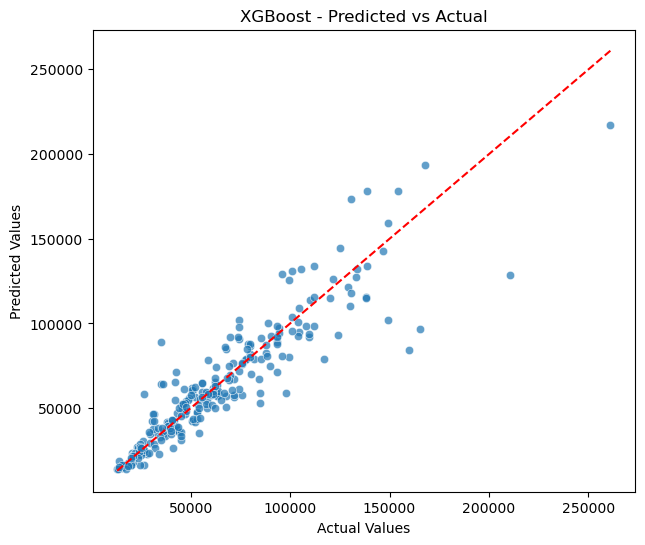

In [34]:
y_pred = best_model.predict(X_test)

# Scatter Plot: Predicted vs Actual
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"{best_name} - Predicted vs Actual")
plt.show()

# Residuals Distribution (Actual - Predicted)

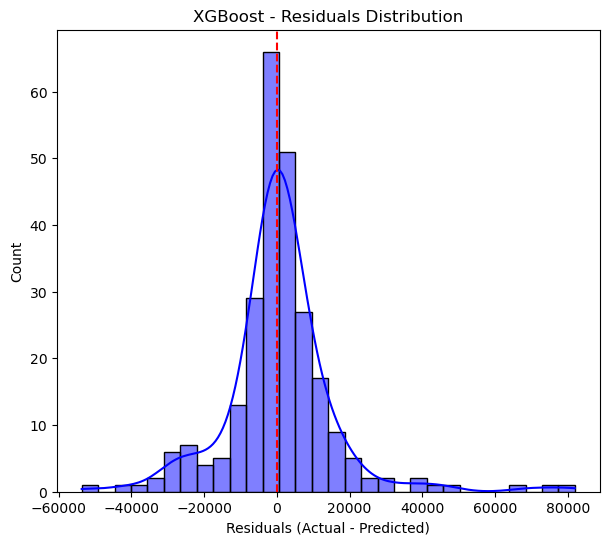

In [35]:
residuals = y_test - y_pred
plt.figure(figsize=(7,6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title(f"{best_name} - Residuals Distribution")
plt.show()

# Feature Importance

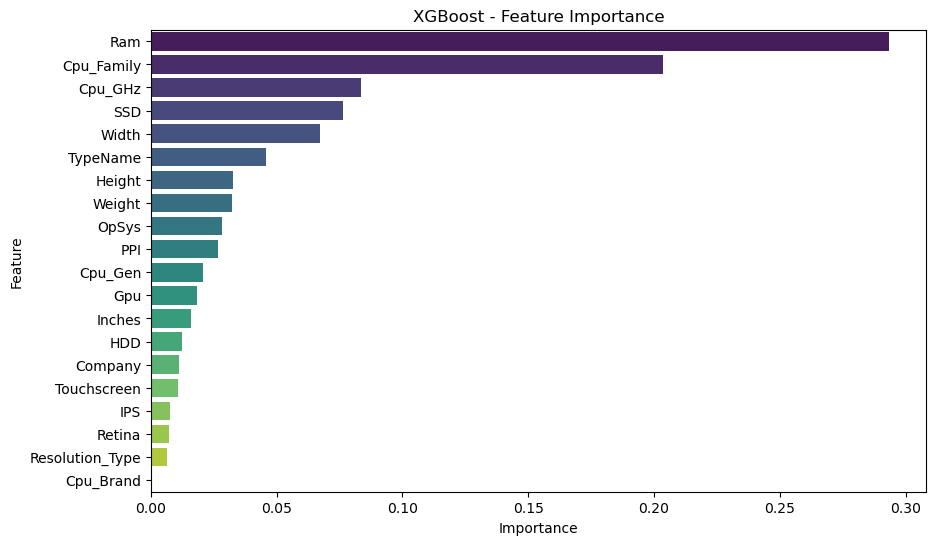

In [36]:
if hasattr(best_model, "feature_importances_"):
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": best_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="viridis")
    plt.title(f"{best_name} - Feature Importance")
    plt.show()
else:
    print(f" Feature importance not available for {best_name}")

# Save Model & Features

In [37]:
feature_columns = X.columns.to_list()
joblib.dump(feature_columns,'features 35.Laptop Price Prediction.joblib')

['features 35.Laptop Price Prediction.joblib']

In [38]:
joblib.dump(best_model,'best model 35.Laptop Price Prediction.joblib')

['best model 35.Laptop Price Prediction.joblib']

# If you have any suggestions, please DM me.
# Even a small message from you can make a big impact on my career
#### I Am Arun